### Load Position Data and Calculate Performance

In [2]:
# Set system path to allow imports
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from ephys import ephys
from session_utils import find_all_sessions
from position_analysis import *


# Load all session names and paths as dict
session_list = find_all_sessions(sheet_path = 'https://docs.google.com/spreadsheets/d/1_Xs5i-rHNTywV-WuQ8-TZliSjTxQCCqGWOD2AL_LIq0/edit#gid=0',
                                 data_path = '/home/isabella/Documents/isabella/jake/recording_data',
                                 sorting_suffix = 'sorting_ks2_custom')


# Constants
max_speed = 5  # m/s
smoothing_window_size = 3  # Choose an appropriate window size for smoothing

In [3]:
processed_posdata = []

# Loop through sessions
trials_loaded = 0
for session, path in session_list.items():
    
    obj = ephys(recording_type = 'nexus', path = path)
    
    # Load position for t-maze trials
    for trial_iterator, trial in enumerate(obj.trial_list):
        if 't-maze' in trial:
            obj.load_pos(trial_iterator, reload_flag = False) #Needs reloading each time for now
            trials_loaded +=1
            
            # Extract XY position data and calculate performance using funcs from position_analysis.py
            xy_pos = obj.pos_data[trial_iterator]['xy_position']
            performance = calculate_choices(xy_pos, assign_sectors(xy_pos.T, pos_header = obj.pos_data[trial_iterator]['header']))
            
            # Add age and animal ID
            obj.pos_data[trial_iterator]['age'] = obj.age
            obj.pos_data[trial_iterator]['animal'] = obj.animal
            
            # Add processed position data to array
            processed_posdata.append({'xy_position': xy_pos,
                                      'age': obj.age,
                                      'animal': obj.animal,
                                      'performance': performance})
                                      

            
print(f'{trials_loaded} t-maze trials loaded')

# Convert processed_posdata to DataFrame
data_df = pd.DataFrame(processed_posdata)

#Extract performance metrics for plotting
data_df['total_choices'] = data_df['performance'].apply(lambda x: x['total_choices'])
data_df['p_correct'] = data_df['performance'].apply(lambda x: x['p_correct'])

Loading pos file: /home/isabella/Documents/isabella/jake/recording_data/r1354/2023-05-03/230503_r1354_raw_t-maze_1.pos
Real PPM artifically set to 615 (t-maze default)


/data/isabella/jake/ephys_analysis/pyScan/analysis/../postprocessing/postprocess_pos_data.py:219: RuntimeWarning: invalid value encountered in remainder
  dir_disp = np.mod(np.arctan2(-pos.iloc[1, 1:].values + pos.iloc[1, :-1].values, pos.iloc[0, 1:].values - pos.iloc[0, :-1].values) * 180 / np.pi, 360)


Loading pos file: /home/isabella/Documents/isabella/jake/recording_data/r1354/2023-05-04/230504_r1354_raw_t-maze_1.pos
Real PPM artifically set to 615 (t-maze default)
Loading pos file: /home/isabella/Documents/isabella/jake/recording_data/r1354/2023-05-05/230505_r1354_raw_t-maze_1.pos
Real PPM artifically set to 615 (t-maze default)
Loading pos file: /home/isabella/Documents/isabella/jake/recording_data/r1354/2023-05-05/230505_r1354_raw_t-maze_2.pos
Real PPM artifically set to 615 (t-maze default)
Loading pos file: /home/isabella/Documents/isabella/jake/recording_data/r1354/2023-05-06/230506_r1354_raw_t-maze_1.pos
Real PPM artifically set to 615 (t-maze default)
Loading pos file: /home/isabella/Documents/isabella/jake/recording_data/r1354/2023-05-06/230506_r1354_raw_t-maze_2.pos
Real PPM artifically set to 615 (t-maze default)
Loading pos file: /home/isabella/Documents/isabella/jake/recording_data/r1354/2023-05-07/230507_r1354_raw_t-maze_1.pos
Real PPM artifically set to 615 (t-maze d

### Plotting:


Plot Age vs Total Choices

/home/isabella/anaconda3/envs/env_37/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


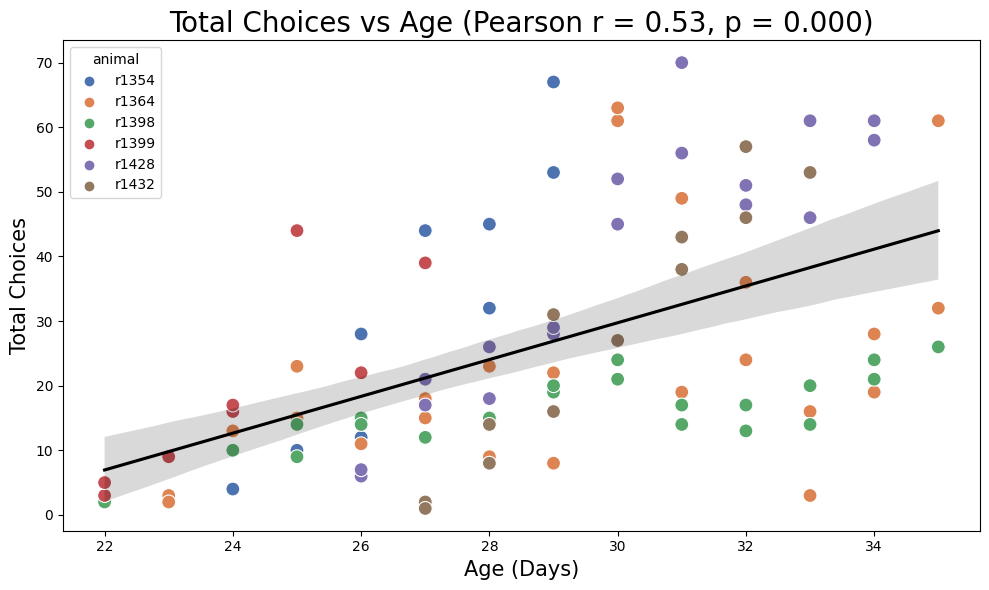

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Remove NaN values
df_clean = data_df.dropna(subset=['age', 'total_choices', 'animal', 'p_correct'])
df_clean['age'] = df_clean['age'].astype(int)

# Calculate the correlation coefficient
corr, p_val = pearsonr(df_clean['age'], df_clean['total_choices'])

plt.figure(figsize= (10, 6))
sns.scatterplot(data=df_clean, x='age', y='total_choices', hue='animal', palette="deep", s = 100)

# If correlation is significant, add a best fit line
if p_val < 0.05:
    sns.regplot(data=df_clean, x='age', y='total_choices', scatter=False, color='black')

plt.xlabel('Age (Days)', fontsize = 15)
plt.ylabel('Total Choices', fontsize = 15)
plt.title(f"Total Choices vs Age (Pearson r = {corr:.2f}, p = {p_val:.3f})", fontsize = 20)
plt.tight_layout()
plt.savefig('/home/isabella/Documents/isabella/jake/ephys_analysis/figures/t-maze_performance/age_vs_total_choices.png')
plt.show()


Plot Age vs Proportion of Correct Choices

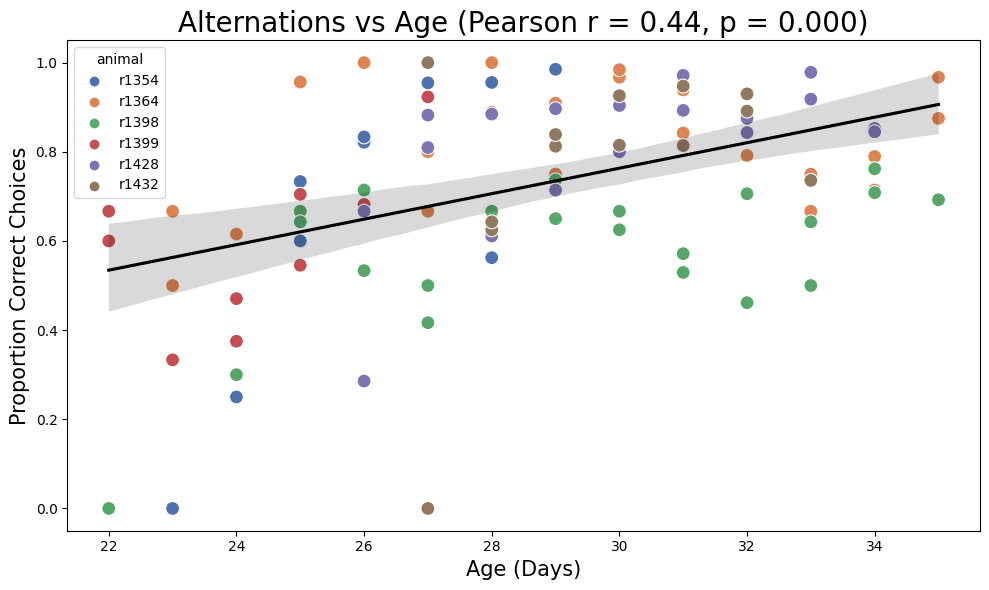

In [12]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='age', y='p_correct', hue='animal', palette="deep", s = 100)

# Calculate the correlation coefficient
corr, p_val = pearsonr(df_clean['age'], df_clean['p_correct'])

# If correlation is significant, add a best fit line
if p_val < 0.05:
    sns.regplot(data=df_clean, x='age', y='p_correct', scatter=False, color='black')

plt.xlabel('Age (Days)', fontsize = 15)
plt.ylabel('Proportion Correct Choices', fontsize = 15)
plt.title(f"Alternations vs Age (Pearson r = {corr:.2f}, p = {p_val:.3f})", fontsize = 20)
plt.tight_layout()
plt.savefig('/home/isabella/Documents/isabella/jake/ephys_analysis/figures/t-maze_performance/age_vs_p_correct.png')
plt.show()


Plot Experience vs Total Choices

/home/isabella/anaconda3/envs/env_37/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


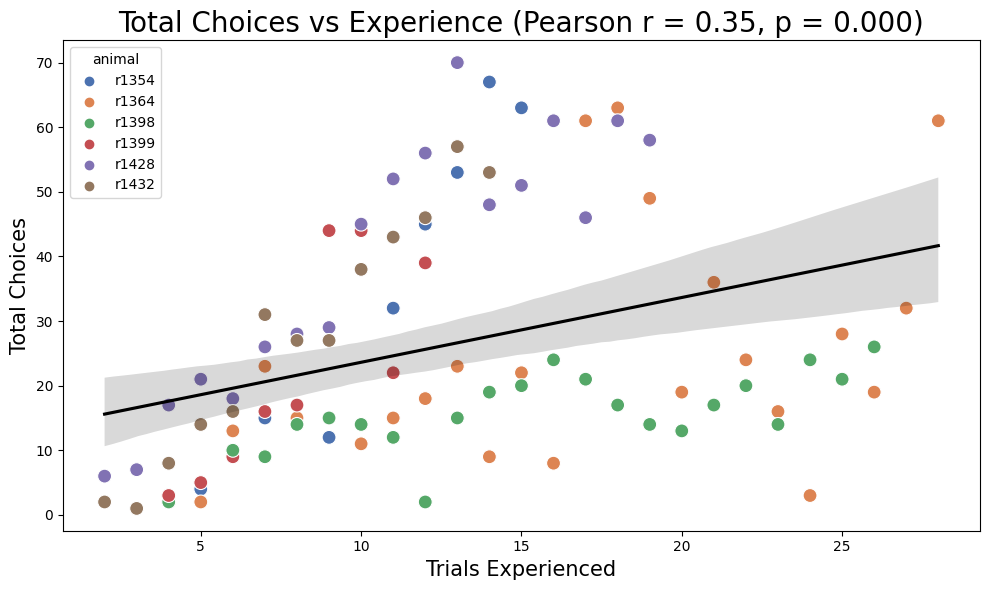

In [13]:
# Get experience from google sheet
from session_utils import gs_to_df

# Load google sheet as DataFrame and get trials of pre-training for each animal
rats_df = gs_to_df('https://docs.google.com/spreadsheets/d/1_Xs5i-rHNTywV-WuQ8-TZliSjTxQCCqGWOD2AL_LIq0/edit#gid=407524738')
data_df['age'] = data_df['age'].astype(int)
data_df['Trials of Pre-training'] = data_df['animal'].apply(lambda x: rats_df.loc[rats_df['ID'] == x, 'Days of pre-training'].values[0])

# Calculate experience
data_df['Trials Recorded'] = data_df.groupby('animal').cumcount()
data_df['Trials Experienced'] = data_df['Trials Recorded'] + data_df['Trials of Pre-training']

# Remove NaN values
df_clean = data_df.dropna(subset=['age', 'total_choices', 'animal', 'p_correct'])
df_clean['age'] = df_clean['age'].astype(int)


# Plot Total Choices vs Experience

# Calculate the correlation coefficient
corr, p_val = pearsonr(df_clean['Trials Experienced'], df_clean['total_choices'])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='Trials Experienced', y='total_choices', hue='animal', palette="deep", s = 100)

# If correlation is significant, add a best fit line
if p_val < 0.05:
    sns.regplot(data=df_clean, x='Trials Experienced', y='total_choices', scatter=False, color='black')

# # Plot best fit lines for each animal individually
# sns.lmplot(data=df_clean, x='Trials Experienced', y='total_choices', hue='animal', palette="deep", scatter_kws={"s": 50})

plt.xlabel('Trials Experienced', fontsize = 15)
plt.ylabel('Total Choices', fontsize = 15)
plt.title(f"Total Choices vs Experience (Pearson r = {corr:.2f}, p = {p_val:.3f})", fontsize = 20)
plt.tight_layout()
plt.savefig('/home/isabella/Documents/isabella/jake/ephys_analysis/figures/t-maze_performance/experience_vs_total_choices.png')

plt.show()

Plot Experience vs Proportion of Correct Choices

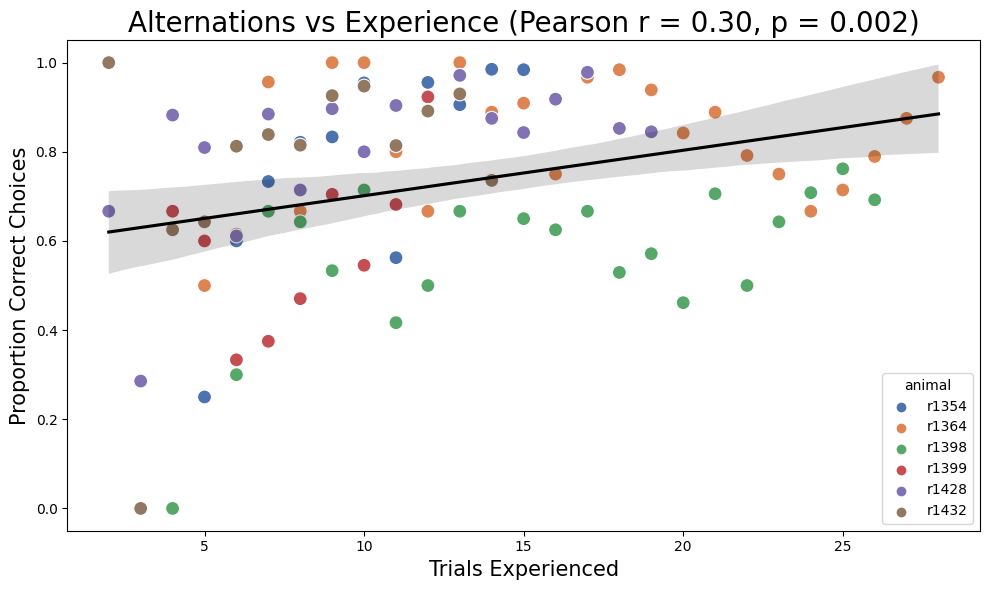

In [7]:
# Plot Experience vs Proportion of Correct Choices

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='Trials Experienced', y='p_correct', hue='animal', palette="deep", s = 100)

# Calculate the correlation coefficient
corr, p_val = pearsonr(df_clean['Trials Experienced'], df_clean['p_correct'])

# If correlation is significant, add a best fit line
if p_val < 0.05:
    sns.regplot(data=df_clean, x='Trials Experienced', y='p_correct', scatter=False, color='black')

plt.xlabel('Trials Experienced', fontsize = 15)
plt.ylabel('Proportion Correct Choices', fontsize = 15)
plt.title(f"Alternations vs Experience (Pearson r = {corr:.2f}, p = {p_val:.3f})", fontsize = 20)
plt.tight_layout()
plt.savefig('/home/isabella/Documents/isabella/jake/ephys_analysis/figures/t-maze_performance/experience_vs_p_correct.png')
plt.show()

### Dissociate age and experience with a mixed linear model regression

For Total Choices

In [72]:
import statsmodels.formula.api as smf

df_clean['Trials_Experienced'] = df_clean['Trials Experienced']

# Define the model
model = smf.mixedlm("total_choices ~ Trials_Experienced + age", df_clean, groups=df_clean["animal"])

# Fit the model
result = model.fit()

# Print the summary
print(result.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  total_choices
No. Observations:    99       Method:              REML         
No. Groups:          6        Scale:               180.7583     
Min. group size:     9        Log-Likelihood:      -399.6994    
Max. group size:     25       Converged:           Yes          
Mean group size:     16.5                                       
----------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept          -83.298   43.836 -1.900 0.057 -169.216  2.619
Trials_Experienced  -0.311    1.029 -0.302 0.763   -2.327  1.705
age                  4.013    1.943  2.065 0.039    0.204  7.822
Group Var          105.279    6.159                             



/home/isabella/anaconda3/envs/env_37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


For Proportion Correct

In [71]:
import statsmodels.formula.api as smf

df_clean['Trials_Experienced'] = df_clean['Trials Experienced']

# Define the model
model = smf.mixedlm("p_correct ~ Trials_Experienced + age", df_clean, groups=df_clean["animal"])

# Fit the model
result = model.fit()

# Print the summary
print(result.summary())

            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   p_correct
No. Observations:   99        Method:               REML     
No. Groups:         6         Scale:                0.0314   
Min. group size:    9         Log-Likelihood:       16.8335  
Max. group size:    25        Converged:            Yes      
Mean group size:    16.5                                     
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          -0.783    0.606 -1.292 0.196 -1.971  0.405
Trials_Experienced -0.017    0.014 -1.211 0.226 -0.045  0.011
age                 0.060    0.027  2.227 0.026  0.007  0.113
Group Var           0.011    0.063                           



/home/isabella/anaconda3/envs/env_37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


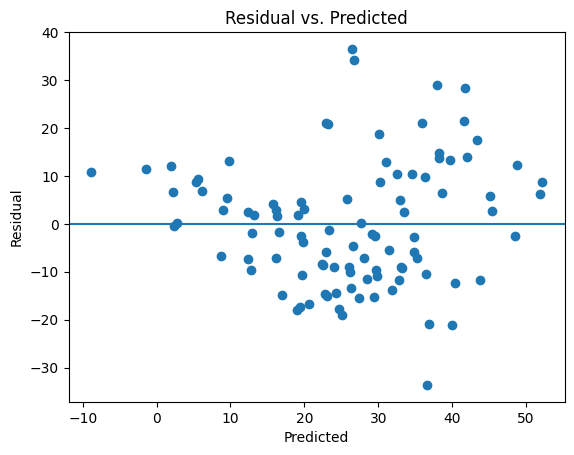

In [73]:
# Check linearity
# If the points are randomly dispersed around the horizontal axis, a linear regression model is appropriate for the data; otherwise, a non-linear model is more appropriate.

import matplotlib.pyplot as plt

predicted_values = result.fittedvalues
residuals = result.resid

plt.scatter(predicted_values, residuals)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

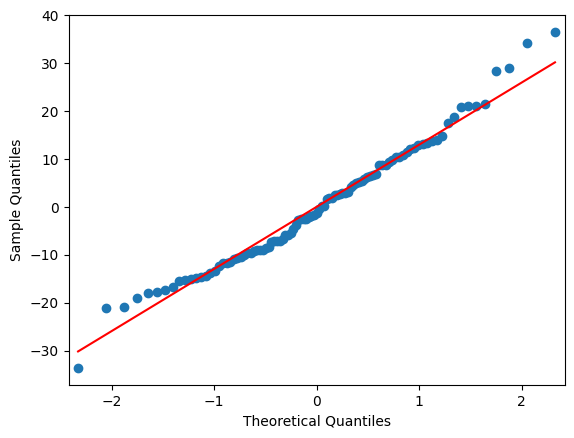

In [74]:
# Check normality
# If the points are approximately on the red line, then the assumption is met.
import statsmodels.api as sm

sm.qqplot(residuals, line='s')
plt.show()

In [78]:
# Check no multicollinearity
# VIF of 1 indicates no correlation between the independent variable and the other variables, 2 ≤ VIF < 5 indicates moderate correlation, and VIF ≥5 indicates severe correlation.
from statsmodels.stats.outliers_influence import variance_inflation_factor


# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(independent_vars.values, i) for i in range(independent_vars.shape[1])]
vif["features"] = independent_vars.columns
print(vif)

   VIF Factor            features
0  161.542046           intercept
1    3.353611  Trials Experienced
2    3.353611                 age


### Unused code:

In [5]:


X = xy_pos.iloc[0,:]
Y = xy_pos.iloc[1,:]
angles = direction_disp  # Random angles in radians

# Create masks for valid (non-nan) X, Y, angles, and speed data
mask = ~np.isnan(X) & ~np.isnan(Y) & ~np.isnan(angles) & ~np.isnan(speed)

# Compute arrow directions, scaled by speed
U = speed[mask] * np.cos(angles[mask])
V = speed[mask] * np.sin(angles[mask])

plt.figure()
#Plot every 10th point for visibility
plt.quiver(X[mask][::10], Y[mask][::10], U[::10], V[::10], angles='xy', scale_units='xy', scale=20)
plt.show()

NameError: name 'direction_disp' is not defined

In [6]:
# Define the reward and start sectors
reward_sectors = [1, 9]
start_sector = 8

sector_numbers = assign_sectors(xy_pos.T)
plt.scatter(xy_pos.iloc[0,:], xy_pos.iloc[1,:], c = sector_numbers)
plt.colorbar()
plt.show()

TypeError: assign_sectors() missing 1 required positional argument: 'pos_header'